In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from triangular_map import *

from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.utils.data.dataloader as dataloader
from torch.autograd import Variable
from torchvision import transforms

import os, math, random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [2]:
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def GMM_sample_iso(N: int, centers: torch.Tensor, stds, weights):
    rand_shape = (N,) if centers.ndim == 1 else (N,centers.shape[-1])
    which_centers = torch.multinomial(weights, N, replacement=True)
    samples = centers[which_centers] + torch.randn(*rand_shape)*stds[which_centers,None]
    return samples, TensorDataset(samples)

In [4]:
# Dataset parameters
N_samples, N_centers, D_ = 5000, 3, 2

In [5]:
# Set the seed deterministically to produce given samples
torch.manual_seed(202382)
# Create predetermined "random" GMM
centers = torch.randn(N_centers, D_)
stds = torch.randn(N_centers)
weights = torch.linspace(1,N_centers+1, steps=N_centers)
weights /= weights.sum()
# Set the seed randomly again for random future initializations
torch.seed()

3002155514835670052

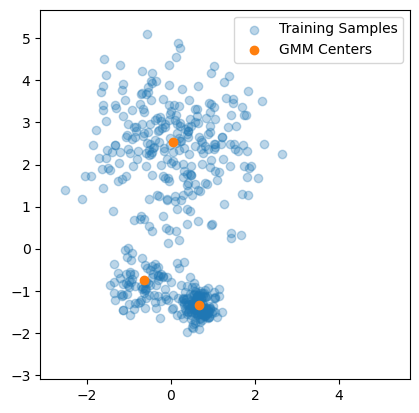

In [6]:
train_samples, training_data = GMM_sample_iso(N_samples, centers, stds, weights)
test_samples, test_data = GMM_sample_iso(N_samples, centers, stds, weights)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

plt.scatter(train_samples[:500,0], train_samples[:500,1], alpha=0.3)
plt.scatter(centers[:,0], centers[:,1])
plt.legend(['Training Samples', 'GMM Centers'])
plt.gca().set_aspect(1)
plt.xlim((train_samples.min(), train_samples.max()))
plt.ylim((train_samples.min(), train_samples.max()))
plt.show()

In [7]:
N_quad = 16
quad_pts, quad_wts = clenshaw_curtis_ab(N_quad)

S = TriangularMapFactory(D_, D_, quad_pts, quad_wts, int_nonlinearity=nn.ReLU, normalization_layer=None, device=device)
S.compile()
with torch.no_grad():
    test_output = S(torch.randn(11,D_, device=device)), S.logdet(torch.randn(7,D_, device=device))
test_output[0].shape, test_output[1].shape

(torch.Size([11, 2]), torch.Size([7]))

In [8]:
optimizer = optim.Adam(S.parameters(), lr=1e-2)

for epoch in range(50):
  S.train(True)
  train_loss = 0
  for (X,) in tqdm(train_loader):
      X = X.to(device)
      optimizer.zero_grad()
      # Z = S(X)
      # nabla_S = S.logdet(X)

      # KL loss = int -log [p(S(X)) |d S(X)| dX
      # log p(Z) = C - 1/2 |Z|^2
      loss = TriangularMapNormalCrossEntropy(S, X)

      loss.backward()
      train_loss += loss.item()
      optimizer.step()

  print('\nEpoch: {} Train Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

100%|██████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.86it/s]



Epoch: 0 Train Loss: 1.3755


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 317.16it/s]



Epoch: 1 Train Loss: 0.9862


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 316.86it/s]



Epoch: 2 Train Loss: 0.9336


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 330.34it/s]



Epoch: 3 Train Loss: 0.9157


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 331.52it/s]



Epoch: 4 Train Loss: 0.9091


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 335.20it/s]



Epoch: 5 Train Loss: 0.8938


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.57it/s]



Epoch: 6 Train Loss: 0.8900


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.14it/s]



Epoch: 7 Train Loss: 0.8682


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.09it/s]



Epoch: 8 Train Loss: 0.8664


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.12it/s]



Epoch: 9 Train Loss: 0.8573


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.32it/s]



Epoch: 10 Train Loss: 0.8553


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.18it/s]



Epoch: 11 Train Loss: 0.8459


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.30it/s]



Epoch: 12 Train Loss: 0.8407


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 339.50it/s]



Epoch: 13 Train Loss: 0.8493


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 342.11it/s]



Epoch: 14 Train Loss: 0.8466


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 339.92it/s]



Epoch: 15 Train Loss: 0.8472


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 335.06it/s]



Epoch: 16 Train Loss: 0.8446


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.98it/s]



Epoch: 17 Train Loss: 0.8370


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.08it/s]



Epoch: 18 Train Loss: 0.8425


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 336.22it/s]



Epoch: 19 Train Loss: 0.8391


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 334.75it/s]



Epoch: 20 Train Loss: 0.8392


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 329.74it/s]



Epoch: 21 Train Loss: 0.8342


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.29it/s]



Epoch: 22 Train Loss: 0.8300


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 341.40it/s]



Epoch: 23 Train Loss: 0.8301


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 329.98it/s]



Epoch: 24 Train Loss: 0.8301


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 334.46it/s]



Epoch: 25 Train Loss: 0.8285


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.47it/s]



Epoch: 26 Train Loss: 0.8382


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 333.45it/s]



Epoch: 27 Train Loss: 0.8317


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 316.67it/s]



Epoch: 28 Train Loss: 0.8290


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 325.77it/s]



Epoch: 29 Train Loss: 0.8304


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 347.84it/s]



Epoch: 30 Train Loss: 0.8464


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 346.68it/s]



Epoch: 31 Train Loss: 0.8320


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 345.92it/s]



Epoch: 32 Train Loss: 0.8499


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 351.47it/s]



Epoch: 33 Train Loss: 0.8399


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 342.14it/s]



Epoch: 34 Train Loss: 0.8343


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 317.93it/s]



Epoch: 35 Train Loss: 0.8267


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 310.31it/s]



Epoch: 36 Train Loss: 0.8287


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.07it/s]



Epoch: 37 Train Loss: 0.8273


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 308.38it/s]



Epoch: 38 Train Loss: 0.8207


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 302.78it/s]



Epoch: 39 Train Loss: 0.8299


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 334.25it/s]



Epoch: 40 Train Loss: 0.8257


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 335.14it/s]



Epoch: 41 Train Loss: 0.8270


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 335.65it/s]



Epoch: 42 Train Loss: 0.8390


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.72it/s]



Epoch: 43 Train Loss: 0.8199


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.09it/s]



Epoch: 44 Train Loss: 0.8254


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.20it/s]



Epoch: 45 Train Loss: 0.8215


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.42it/s]



Epoch: 46 Train Loss: 0.8252


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.83it/s]



Epoch: 47 Train Loss: 0.8250


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 337.65it/s]



Epoch: 48 Train Loss: 0.8256


100%|█████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 338.79it/s]


Epoch: 49 Train Loss: 0.8223


In [9]:
samps = sample_normal_ref(S, 5000, device=device)

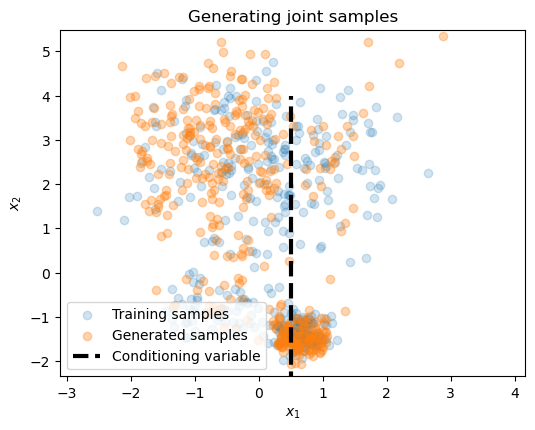

In [10]:
samps_np = samps.cpu().detach().numpy()
fixed_x = 0.5
N_plot = 400
fig = plt.figure(figsize=(6.,4.5))
plt.scatter(train_samples[:N_plot,0], train_samples[:N_plot,1], alpha=0.2, label="Training samples")
plt.scatter(samps_np[:N_plot,0], samps_np[:N_plot,1], alpha=0.33, label="Generated samples")
plt.vlines(fixed_x, -4, 4, ls="dashed", lw=3, color="k", label="Conditioning variable")
plt.legend(loc="lower left")
# plt.gca().set_aspect(1)
plt.xlim((train_samples[:,0].min(), train_samples[:,0].max()))
plt.ylim((train_samples[:,1].min()-0.2, train_samples[:,1].max()-0.2))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Generating joint samples")
plt.savefig("figs/two_dim/joint_samples.png")
fig.show()

In [11]:
S2 = TriangularMap(2, 1, S.components[-1:])
x = torch.ones((1,), device=device)*fixed_x
cond_samples = sample_normal_ref(S2, 5000, x, device=device)

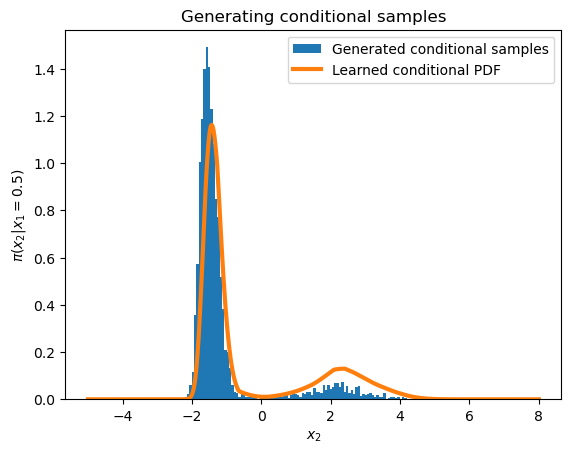

In [12]:
N_pdf = 500
pdf_xrange = torch.linspace(-5, 8, N_pdf, device=device)
pdf_input = torch.stack((fixed_x*torch.ones((N_pdf,),device=device), pdf_xrange),1)
pdf_eval = (-0.5*(S2(pdf_input).reshape(-1)**2) + S2.logdet(pdf_input).reshape(-1)).exp()/np.sqrt(2*np.pi)
pdf_xrange_cpu = pdf_xrange.cpu().detach().numpy()
pdf_eval_cpu = pdf_eval.cpu().detach().numpy()
plt.hist(cond_samples.cpu().detach().numpy().flatten(), bins=100, density=True, label="Generated conditional samples")
plt.plot(pdf_xrange_cpu, pdf_eval_cpu, lw=3, label="Learned conditional PDF")
plt.legend()
plt.xlabel(r"$x_2$")
plt.ylabel(r"$\pi(x_2|x_1=0.5)$")
plt.title("Generating conditional samples")
plt.savefig("figs/two_dim/cond_samples.png")
plt.show()